In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchinfo import summary

# read MNIST training data
df = pd.read_csv('./data/mnist_train.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()                # labels of images

# divide the data into batches (we loop through the batches in training)
batch_size = 32
batches = int(np.ceil(X.shape[0]/batch_size))
X_batched = np.array_split(X, batches)
y_batched = np.array_split(y, batches)

X_batched = torch.tensor(X_batched,dtype=torch.float32)
y_batched = torch.tensor(y_batched,dtype=torch.int64)

/tmp/ipykernel_130280/554381706.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/torch/csrc/utils/tensor_new.cpp:245.)
  X_batched = torch.tensor(X_batched,dtype=torch.float32)


Here we defined our auto encoder and decoder acording to the specifications

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.dense1 = nn.Linear(784,100)
        self.dense2 = nn.Linear(100,30)
        self.dense3 = nn.Linear(30,100)
        self.dense4 = nn.Linear(100,784)
    def forward(self, x):
        x = self.dense1(x)
        x = F.selu(x)
        x = self.dense2(x)
        x = F.selu(x)
        x = self.dense3(x)
        x = F.selu(x)
        x = self.dense4(x)
        return x
 
model = MLP()
summary(model, input_size=(1,784),col_names=("input_size","output_size","num_params"), row_settings=["var_names"],)


Layer (type (var_name))                  Input Shape               Output Shape              Param #
MLP (MLP)                                [1, 784]                  [1, 784]                  --
├─Linear (dense1)                        [1, 784]                  [1, 100]                  78,500
├─Linear (dense2)                        [1, 100]                  [1, 30]                   3,030
├─Linear (dense3)                        [1, 30]                   [1, 100]                  3,100
├─Linear (dense4)                        [1, 100]                  [1, 784]                  79,184
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.66
Estimated Total Size (MB): 0.67

Here for our auto encoder we want to measure how close our generated output is to the input, therefore we use mean squared error to observe loss:
$$J(\theta)=\frac{1}{N}\sum _{i=1}^N (x-\hat{x}_i)^2$$

In [8]:
loss_function = nn.MSELoss()
def train(X_batched,y_batched):
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

    loss_values = []
    running_loss = 0.0
    for epoch in range(20):
        for b in range(batches):
            optimizer.zero_grad()
            inputs, labels = X_batched[b], X_batched[b] #CHANGE THIS
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if b%100 ==99:
                print(f'[{epoch+1}, {b+1:5d}] loss: {running_loss/100:.3f}')
                loss_values.append(running_loss/100)
                running_loss = 0.0
    
    return loss_values


loss_values = train(X_batched,y_batched)
print("Finished Training")

[1,   100] loss: 0.117
[1,   200] loss: 0.110
[1,   300] loss: 0.095
[1,   400] loss: 0.090
[1,   500] loss: 0.080
[1,   600] loss: 0.071
[1,   700] loss: 0.071
[1,   800] loss: 0.067
[1,   900] loss: 0.064
[1,  1000] loss: 0.062
[1,  1100] loss: 0.063
[1,  1200] loss: 0.064
[1,  1300] loss: 0.063
[1,  1400] loss: 0.062
[1,  1500] loss: 0.062
[1,  1600] loss: 0.062
[1,  1700] loss: 0.061
[1,  1800] loss: 0.061
[2,   100] loss: 0.107
[2,   200] loss: 0.062
[2,   300] loss: 0.060
[2,   400] loss: 0.061
[2,   500] loss: 0.061
[2,   600] loss: 0.059
[2,   700] loss: 0.062
[2,   800] loss: 0.060
[2,   900] loss: 0.059
[2,  1000] loss: 0.057
[2,  1100] loss: 0.058
[2,  1200] loss: 0.059
[2,  1300] loss: 0.058
[2,  1400] loss: 0.057
[2,  1500] loss: 0.057
[2,  1600] loss: 0.057
[2,  1700] loss: 0.056
[2,  1800] loss: 0.056
[3,   100] loss: 0.097
[3,   200] loss: 0.056
[3,   300] loss: 0.054
[3,   400] loss: 0.055
[3,   500] loss: 0.055
[3,   600] loss: 0.053
[3,   700] loss: 0.055
[3,   800] 

We observe the loss decrease to 0.025 which is remarkable

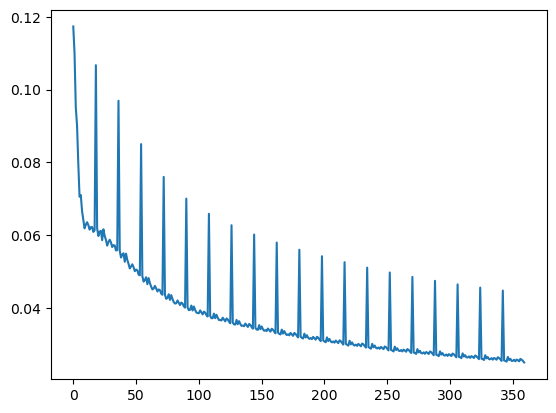

In [11]:
plt.plot(loss_values)

The code is able to reconstruct our data with surprising accuracy. This means our training data was able to be compressed to 30 dimension vector without losing semantic meaning.

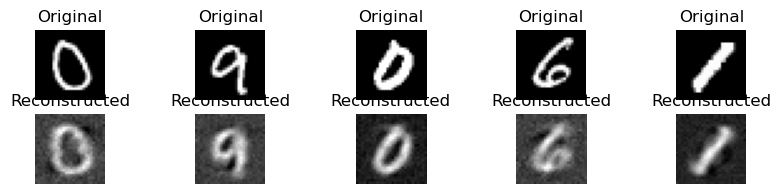

In [12]:
def test_reconstruction(model, X_batched, num_examples=5):
    # Turn the model to evaluation mode
    model.eval()
    # Randomly select a few examples
    indices = np.random.choice(len(X), num_examples)
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_examples, figsize=(10, 2))
    for i, idx in enumerate(indices):
        original = X[idx]
        original_img = original.reshape(28, 28)
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        # Convert to tensor and add an additional batch dimension
        original_tensor = torch.tensor(original, dtype=torch.float32).unsqueeze(0)
        # Get the model output for the selected example
        reconstructed_tensor = model(original_tensor)
        # The output tensor may need to be detached and converted back to numpy
        reconstructed = reconstructed_tensor.detach().numpy().reshape(28, 28)
        axes[1, i].imshow(reconstructed, cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

# Call the test function
test_reconstruction(model, X_batched)